In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from observational_fear import load
from observational_fear.events import get_block_starts

from binit.bin import which_bin_idx
from binit.align import align_around
from neurobox.wide_transforms import resample

from sklearn.decomposition import PCA
from scipy.spatial import distance
from scipy.stats import zscore


sns.set_style("whitegrid")
DATA_DIR = Path(r"F:\OFL\one-p experiment\data")
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")

In [3]:
def get_trajectories(X, num_pcs=2, return_mod=False, mod=None):
    def _centroid_distances(df):
        centroid_pre = df.loc[df.index < 0].mean().values
        centroid_post = df.loc[df.index >=0].mean().values
        d_pre = df.bfill().apply(lambda x: distance.euclidean(x.values, centroid_pre), axis=1)
        d_post = df.bfill().apply(lambda x: distance.euclidean(x.values, centroid_post), axis=1)
        df_distance = pd.DataFrame({"d_centroid_pre": d_pre, "d_centroid_post":d_post})
        return pd.concat([df, df_distance], axis=1)
    
    if mod is None:
        mod = PCA(num_pcs).fit(X)
    df =  pd.DataFrame(mod.transform(X), columns=[f"PC{i}" for i in range(1, num_pcs + 1)])
    df["time"] = X.index
    df.index = X.index
    df = _centroid_distances(df)
    if return_mod:
        return df, mod
    else:
        return df

def get_psth(df, events, t_before=5, t_after=5):
    df["aligned"] = align_around(df["time"].values, events, t_before=t_before, max_latency=t_after)
    df["aligned"] = df["aligned"].round(2)
    df = df.pivot_table(columns="new_id", values="value", index="aligned")
    df = df.apply(zscore)
    return df

def get_trajectories_by_trial(df, events, mod, num_pcs=2, time_before=5, time_after=5, time_col="time"):
    def pivot_tradjectory(df, time_col="aligned", neuron_col="new_id", value_col="value"):
        df_piv = df.pivot(index=time_col, columns=neuron_col, values=value_col)
        df_piv = df_piv.apply(zscore).fillna(0)
        df_tidy = get_trajectories(df_piv, num_pcs=num_pcs, mod=mod, return_mod=False)
        return df_tidy
    
    df["trial_idx"] = which_bin_idx(
        df[time_col].values,
        bin_edges=events,
        time_before=time_before,
        time_after=time_after,
    )
    df["aligned"] = align_around(
        df[time_col].values, events, t_before=time_before, max_latency=time_after
    )
    df["aligned"] = np.round(df["aligned"], 2)
    return (
        df.groupby("trial_idx")
        .apply(pivot_tradjectory)
        .reset_index()
    )

def plot_trajectories(df, ax=None):
    if ax is None:
        _, ax = plt.subplots(subplot_kw={'projection': '3d'})
    for trial in df["trial_idx"].unique():
        dfp = df[df["trial_idx"] == trial].sort_values("aligned")
        ax.plot(dfp["aligned"], dfp["PC1"], dfp["PC2"], alpha=0.2, color="black")
    
    dfp = df.groupby(["aligned"], as_index=False)[["PC1", "PC2"]].mean()
    dfp = dfp.sort_values("aligned")
    ax.plot(dfp["aligned"], dfp["PC1"], dfp["PC2"], linewidth=2, color="black")
    ax.set_xlabel('Time')
    ax.set_ylabel('PC1')
    ax.set_zlabel('PC2')
    return ax

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


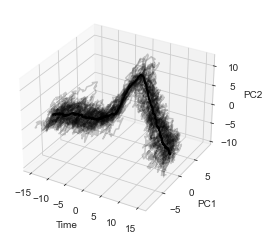

In [4]:
session = "day2"
block = "US"
time_before=15
time_after=15


df = load.load_traces(DATA_DIR, session=session)
df = resample(df.set_index("time"), "100ms").reset_index().melt(id_vars=["time"])
events = get_block_starts(session=session, block_name=block)
psth = get_psth(df, events, t_before=time_before, t_after=time_after)
trad, mod = get_trajectories(psth, return_mod=True)
res = get_trajectories_by_trial(df, events, mod, time_before=time_before, time_after=time_after)
ax = plot_trajectories(res)
loadings = mod.components_.T * np.sqrt(mod.explained_variance_)
loadings = pd.DataFrame({"neuron_id": psth.columns, "PC1": loadings[:, 0], "PC2": loadings[:, 1]})

# trad.reset_index().to_csv(DATA_DIR / f"Trajectories - {session} - {block}.csv", index=False)
# loadings.to_csv(DATA_DIR / f"PC Loadings - {session} - {block}.csv", index=False)
plt.savefig(FIG_DIR / f"Trajectories - {session} - {block}.svg")

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


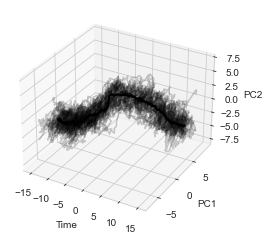

In [5]:
session = "day2"
block = "CS"

time_before=15
time_after=15

df = load.load_traces(DATA_DIR, session=session)
df = resample(df.set_index("time"), "100ms").reset_index().melt(id_vars=["time"])
events = get_block_starts(session=session, block_name=block)
psth = get_psth(df, events, t_before=time_before, t_after=time_after)
trad, mod = get_trajectories(psth, return_mod=True)
res = get_trajectories_by_trial(df, events, mod, time_before=time_before, time_after=time_after)
ax = plot_trajectories(res)
loadings = mod.components_.T * np.sqrt(mod.explained_variance_)
loadings = pd.DataFrame({"neuron_id": psth.columns, "PC1": loadings[:, 0], "PC2": loadings[:, 1]})


# trad.reset_index().to_csv(DATA_DIR / f"Trajectories - {session} - {block}.csv", index=False)
# loadings.to_csv(DATA_DIR / f"PC Loadings - {session} - {block}.csv", index=False)
plt.savefig(FIG_DIR / f"Trajectories - {session} - {block}.svg")

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


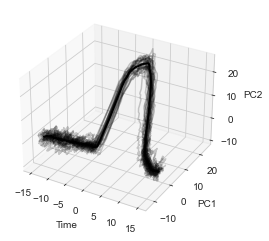

In [6]:
session = "day4"
block = "US"
time_before=15
time_after=15

df = load.load_traces(DATA_DIR, session=session)
df = resample(df.set_index("time"), "100ms").reset_index().melt(id_vars=["time"])
events = get_block_starts(session=session, block_name=block)
psth = get_psth(df, events, t_before=time_before, t_after=time_after)
trad, mod = get_trajectories(psth, return_mod=True)
res = get_trajectories_by_trial(df, events, mod, time_before=time_before, time_after=time_after)
ax = plot_trajectories(res)
loadings = mod.components_.T * np.sqrt(mod.explained_variance_)
loadings = pd.DataFrame({"neuron_id": psth.columns, "PC1": loadings[:, 0], "PC2": loadings[:, 1]})


# trad.reset_index().to_csv(DATA_DIR / f"Trajectories - {session} - {block}.csv", index=False)
# loadings.to_csv(DATA_DIR / f"PC Loadings - {session} - {block}.csv", index=False)
plt.savefig(FIG_DIR / f"Trajectories - {session} - {block}.svg")

In [263]:
def get_freeze_psth(df):
    return df.pivot_table(columns="new_id", values="value", index="aligned").apply(zscore)


def get_freeze_trajectories_by_trial(df, mod, num_pcs=2, thresh=1000):
    def pivot_tradjectory(df, time_col="aligned", neuron_col="new_id", value_col="value"):
        df_piv = df.pivot_table(index=time_col, columns=neuron_col, values=value_col)
        df_piv = df_piv.apply(zscore).fillna(0)
        df_tidy = get_trajectories(df_piv, num_pcs=num_pcs, mod=mod, return_mod=False)
        return df_tidy
    
    return (
        df.groupby("event")
        .apply(pivot_tradjectory)
        .reset_index()
    )

def plot_trajectories(df, ax=None):
    if ax is None:
        _, ax = plt.subplots(subplot_kw={'projection': '3d'})
    for trial in df["event"].unique():
        dfp = df[df["event"] == trial].sort_values("aligned")
        ax.plot(dfp["aligned"], dfp["PC1"], dfp["PC2"], alpha=0.2, color="black")
    
    dfp = df.groupby(["aligned"], as_index=False)[["PC1", "PC2"]].mean()
    dfp = dfp.sort_values("aligned")
    ax.plot(dfp["aligned"], dfp["PC1"], dfp["PC2"], linewidth=2, color="black")
    ax.set_xlabel('Time')
    ax.set_ylabel('PC1')
    ax.set_zlabel('PC2')
    return ax


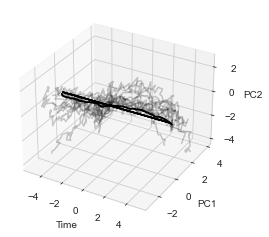

In [264]:
session = "day2"
start_stop="start"


df = load.load_freeze_cache(data_dir=DATA_DIR, session=session, startstop=start_stop)

# data cleaning
max_neurons = df.groupby("event")["new_id"].nunique().max()
df = df.groupby("event").filter(lambda x: (x["new_id"].nunique() == max_neurons) & (x["aligned"].nunique() >=100))
df = df.loc[lambda x: x.event < 60]

psth = df.pivot_table(columns="new_id", values="value", index="aligned").apply(zscore)

trad, mod = get_trajectories(psth, return_mod=True)
print(psth.shape)
res = get_freeze_trajectories_by_trial(df, mod)
ax = plot_trajectories(res)
loadings = mod.components_.T * np.sqrt(mod.explained_variance_)
loadings = pd.DataFrame({"neuron_id": psth.columns, "PC1": loadings[:, 0], "PC2": loadings[:, 1]})


trad.reset_index().to_csv(DATA_DIR / f"Trajectories - {session} - {start_stop}.csv", index=False)
loadings.to_csv(DATA_DIR / f"PC Loadings - {session} - Freeze {start_stop}.csv", index=False)
plt.savefig(FIG_DIR / f"Trajectories - {session} - Freeze {start_stop}.svg")

(101, 1089)


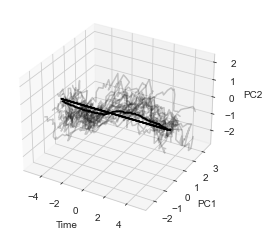

In [265]:
session = "day2"
start_stop="stop"


df = load.load_freeze_cache(data_dir=DATA_DIR, session=session, startstop=start_stop)

# data cleaning
max_neurons = df.groupby("event")["new_id"].nunique().max()
df = df.groupby("event").filter(lambda x: (x["new_id"].nunique() == max_neurons) & (x["aligned"].nunique() >=100))
df = df.loc[lambda x: x.event < 60]

psth = df.pivot_table(columns="new_id", values="value", index="aligned").apply(zscore)

trad, mod = get_trajectories(psth, return_mod=True)
print(psth.shape)
res = get_freeze_trajectories_by_trial(df, mod)
ax = plot_trajectories(res)
loadings = mod.components_.T * np.sqrt(mod.explained_variance_)
loadings = pd.DataFrame({"neuron_id": psth.columns, "PC1": loadings[:, 0], "PC2": loadings[:, 1]})


trad.reset_index().to_csv(DATA_DIR / f"Trajectories - {session} - {start_stop}.csv", index=False)
loadings.to_csv(DATA_DIR / f"PC Loadings - {session} - Freeze {start_stop}.csv", index=False)
plt.savefig(FIG_DIR / f"Trajectories - {session} - Freeze {start_stop}.svg")

(101, 1076)


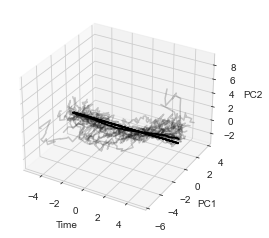

In [266]:
session = "day4"
start_stop="start"


df = load.load_freeze_cache(data_dir=DATA_DIR, session=session, startstop=start_stop)

# data cleaning
max_neurons = df.groupby("event")["new_id"].nunique().max()
df = df.groupby("event").filter(lambda x: (x["new_id"].nunique() == max_neurons) & (x["aligned"].nunique() >=100))
df = df.loc[lambda x: x.event < 60]

psth = df.pivot_table(columns="new_id", values="value", index="aligned").apply(zscore)

trad, mod = get_trajectories(psth, return_mod=True)
print(psth.shape)
res = get_freeze_trajectories_by_trial(df, mod)
ax = plot_trajectories(res)
loadings = mod.components_.T * np.sqrt(mod.explained_variance_)
loadings = pd.DataFrame({"neuron_id": psth.columns, "PC1": loadings[:, 0], "PC2": loadings[:, 1]})


trad.reset_index().to_csv(DATA_DIR / f"Trajectories - {session} - {start_stop}.csv", index=False)
loadings.to_csv(DATA_DIR / f"PC Loadings - {session} - Freeze {start_stop}.csv", index=False)
plt.savefig(FIG_DIR / f"Trajectories - {session} - Freeze {start_stop}.svg")

(101, 1076)


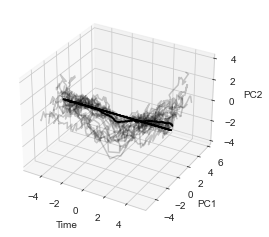

In [267]:
session = "day4"
start_stop="stop"


df = load.load_freeze_cache(data_dir=DATA_DIR, session=session, startstop=start_stop)

# data cleaning
max_neurons = df.groupby("event")["new_id"].nunique().max()
df = df.groupby("event").filter(lambda x: (x["new_id"].nunique() == max_neurons) & (x["aligned"].nunique() >=100))
df = df.loc[lambda x: x.event < 60]

psth = df.pivot_table(columns="new_id", values="value", index="aligned").apply(zscore)

trad, mod = get_trajectories(psth, return_mod=True)
print(psth.shape)
res = get_freeze_trajectories_by_trial(df, mod)
ax = plot_trajectories(res)
loadings = mod.components_.T * np.sqrt(mod.explained_variance_)
loadings = pd.DataFrame({"neuron_id": psth.columns, "PC1": loadings[:, 0], "PC2": loadings[:, 1]})


trad.reset_index().to_csv(DATA_DIR / f"Trajectories - {session} - {start_stop}.csv", index=False)
loadings.to_csv(DATA_DIR / f"PC Loadings - {session} - Freeze {start_stop}.csv", index=False)
plt.savefig(FIG_DIR / f"Trajectories - {session} - Freeze {start_stop}.svg")